## **Advanced Programming in Python & R Project**
## **Electrical Load Forecasting using Machine Learning**
### Team Members:
### 1. Ehtesham Ashraf (23303021)
### 2. Rohit Solan (23303018)
### 3. Abdul Qadir (23303017)
### 4. Umar Farooq (23303013)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing required libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime
import plotly.express as px
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [ ]:
path = "/content/drive/MyDrive/Adv_Python_and_R_Project/2017_smd_hourly.xlsx"

Loading dataset

In [ ]:
df = pd.read_excel(path,sheet_name='CT')
df.head()

,Date,Hr_End,DA_Demand,RT_Demand,DA_LMP,DA_EC,DA_CC,DA_MLC,RT_LMP,RT_EC,RT_CC,RT_MLC,Dry_Bulb,Dew_Point
0,2017-01-01,1,2730.6,2842.286,34.84,34.86,0.0,-0.02,36.48,36.53,0.0,-0.05,37,30
1,2017-01-01,2,2583.5,2706.953,33.80,33.72,0.0,0.08,37.01,37.02,0.0,-0.01,37,30
2,2017-01-01,3,2498.3,2601.690,32.49,32.40,0.0,0.09,35.77,35.79,0.0,-0.02,36,31
3,2017-01-01,4,2465.8,2535.487,25.98,25.88,0.0,0.10,34.06,34.04,0.0,0.02,36,31
4,2017-01-01,5,2500.7,2524.593,29.71,29.65,0.0,0.06,35.42,35.36,0.0,0.06,36,30


#### **Feature Selection**

In [ ]:
df = df[['Date','Hr_End','Dry_Bulb','Dew_Point','RT_Demand']]
df.head()

,Date,Hr_End,Dry_Bulb,Dew_Point,RT_Demand
0,2017-01-01,1,37,30,2842.286
1,2017-01-01,2,37,30,2706.953
2,2017-01-01,3,36,31,2601.690
3,2017-01-01,4,36,31,2535.487
4,2017-01-01,5,36,30,2524.593


In [ ]:
dfs = []
for i in range(2017,2024):
    d = pd.read_excel(path.replace("2017",str(i)),sheet_name='CT')
    d = d[['Date','Hr_End','Dry_Bulb','Dew_Point','RT_Demand']]
    dfs.append(d)
df = pd.concat(dfs,axis=0,ignore_index=True)
df

,Date,Hr_End,Dry_Bulb,Dew_Point,RT_Demand
0,2017-01-01,1,37,30,2842.286
1,2017-01-01,2,37,30,2706.953
2,2017-01-01,3,36,31,2601.690
3,2017-01-01,4,36,31,2535.487
4,2017-01-01,5,36,30,2524.593
...,...,...,...,...,...
58411,2023-08-31,20,71,49,3649.015
58412,2023-08-31,21,66,45,3511.249
58413,2023-08-31,22,61,46,3231.820
58414,2023-08-31,23,60,47,2915.013


In [ ]:
df.isnull().sum()

Date         0
Hr_End       0
Dry_Bulb     0
Dew_Point    0
RT_Demand    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

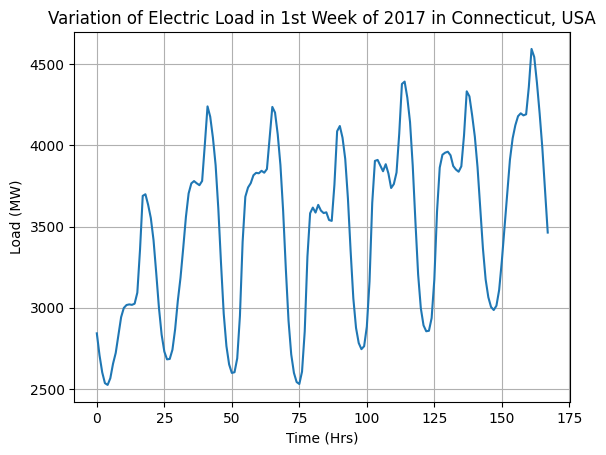

In [ ]:
plt.plot(df['RT_Demand'][:168])
plt.title("Variation of Electric Load in 1st Week of 2017 in Connecticut, USA")
plt.xlabel("Time (Hrs)")
plt.ylabel("Load (MW)")
plt.grid()
plt.show()

#### **Feature Extraction**

In [ ]:
X = pd.DataFrame(df[['Date','Dry_Bulb','Dew_Point','Hr_End']])
X['Month'] = pd.to_datetime(df['Date']).dt.month
X['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek

In [ ]:
hol = pd.read_excel(path.replace("2017_smd_hourly","Holidays 2017_AUG2023"))
hol = list(hol['Date'])

In [ ]:
wdi = []
for r in X.itertuples():
    if(r.DayOfWeek not in [5,6] and r.Date not in list(hol)):
        wdi.append(1)
    else:
        wdi.append(0)
X['WorkingDayIndicator'] = pd.Series(wdi)

In [ ]:
X['PrevDaySameHrLoad'] = df['RT_Demand'].shift(periods=24)
X['PrevWeekSameHrLoad'] = df['RT_Demand'].shift(periods=168)
X.drop('Date',axis=1,inplace=True)
X = X[168:]
X.reset_index(drop=True,inplace=True)
X.head(24)

,Dry_Bulb,Dew_Point,Hr_End,Month,DayOfWeek,WorkingDayIndicator,PrevDaySameHrLoad,PrevWeekSameHrLoad
0,19,14,1,1,6,0,3174.454,2842.286
1,17,11,2,1,6,0,3064.702,2706.953
2,15,10,3,1,6,0,3004.804,2601.690
3,14,9,4,1,6,0,2985.784,2535.487
4,12,8,5,1,6,0,3012.564,2524.593
5,12,6,6,1,6,0,3108.602,2565.818
6,11,2,7,1,6,0,3287.192,2654.909
7,9,2,8,1,6,0,3497.413,2721.647
8,9,2,9,1,6,0,3715.583,2830.195
9,12,3,10,1,6,0,3910.962,2942.015


In [ ]:
X.describe()

,Dry_Bulb,Dew_Point,Hr_End,Month,DayOfWeek,WorkingDayIndicator,PrevDaySameHrLoad,PrevWeekSameHrLoad
count,58248.000000,58248.000000,58248.000000,58248.000000,58248.000000,58248.000000,58248.000000,58248.000000
mean,52.592793,40.332853,12.500000,6.339926,2.998764,0.690977,3217.069667,3217.153844
std,19.030013,19.604508,6.922246,3.397146,2.000326,0.462095,721.902294,721.795060
min,-9.000000,-29.000000,1.000000,1.000000,0.000000,0.000000,1859.179000,1859.179000
25%,37.000000,25.000000,6.750000,3.000000,1.000000,0.000000,2708.997000,2709.218000
50%,53.000000,41.000000,12.500000,6.000000,3.000000,1.000000,3136.127000,3136.255500
75%,68.000000,57.000000,18.250000,9.000000,5.000000,1.000000,3605.949500,3606.081250
max,100.000000,77.000000,24.000000,12.000000,6.000000,1.000000,6591.295000,6591.295000


In [ ]:
Y = df['RT_Demand'][168:]
Y.reset_index(drop=True,inplace=True)

In [ ]:
ig = mutual_info_regression(X,Y)
ig = pd.DataFrame({'Feature': X.columns, 'Info Gain': ig})
ig = ig.sort_values(by='Info Gain',ascending=False)
fig = px.bar(ig, x='Info Gain', y='Feature', orientation='h',
             title='Mutual Information Gains for Features',
             labels={'Info Gain': 'Mutual Information Gain', 'Feature': 'Feature'},
             template='plotly',
             color='Info Gain',
             )
fig.update_layout(yaxis=dict(categoryorder='total ascending'))
fig.show()

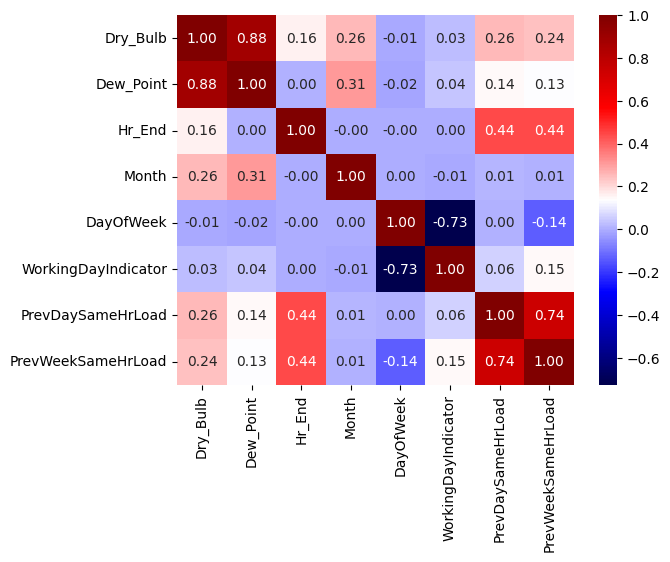

In [ ]:
sns.heatmap(X.corr(),annot=True,cmap='seismic',fmt='.2f')
plt.show()

In [ ]:
rs = 42
XTrain, XTest, YTrain, YTest = train_test_split(X,Y,test_size=0.2,random_state=rs)

In [ ]:
model = RandomForestRegressor(random_state=42,n_jobs=-1,verbose=1)
model.fit(XTrain,YTrain)
ypred = model.predict(XTest)
mape = (abs(YTest-ypred)/YTest * 100).mean()
mae = abs(YTest-ypred).mean()
print("MAPE =",round(mape,2),"%")
print("MAE =",round(mae,2),"MW")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


MAPE = 2.95 %
MAE = 95.81 MW


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


#### **Hyperparameter Tuning**

In [ ]:
def hppmtuner(rf,param_grid,bp):
  grid_search = GridSearchCV(rf,param_grid,n_jobs=-1,verbose=2,
                             cv=3,scoring='neg_mean_absolute_percentage_error')
  grid_search.fit(XTrain, YTrain)
  param_grid.popitem()
  v = grid_search.best_params_[bp]
  param_grid[bp] = [v]
  return param_grid, grid_search

Tuning Hyperparameter : max_features
Fitting 3 folds for each of 8 candidates, totalling 24 fits


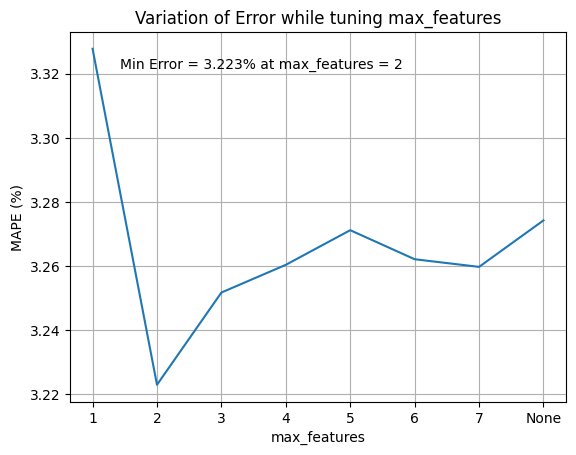


Optimal Feature Set : {'max_features': [2]}
Best Estimator : RandomForestRegressor(max_features=2, n_estimators=20, n_jobs=-1,
                      random_state=42) 

Tuning Hyperparameter : max_samples
Fitting 3 folds for each of 5 candidates, totalling 15 fits


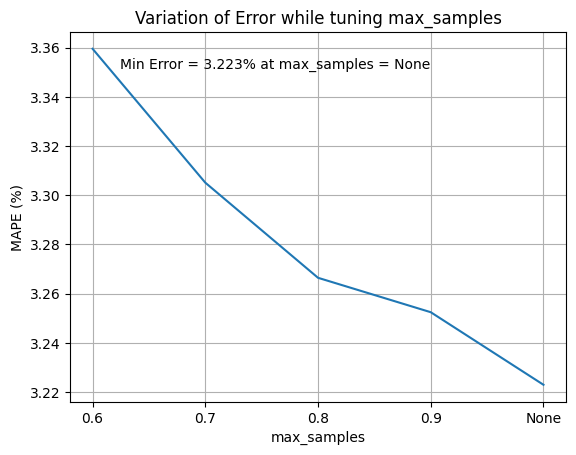


Optimal Feature Set : {'max_features': [2], 'max_samples': [None]}
Best Estimator : RandomForestRegressor(max_features=2, n_estimators=20, n_jobs=-1,
                      random_state=42) 

Tuning Hyperparameter : max_depth
Fitting 3 folds for each of 7 candidates, totalling 21 fits


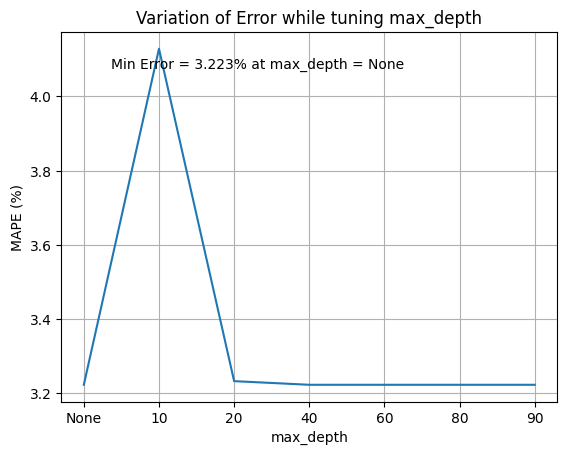


Optimal Feature Set : {'max_features': [2], 'max_samples': [None], 'max_depth': [None]}
Best Estimator : RandomForestRegressor(max_features=2, n_estimators=20, n_jobs=-1,
                      random_state=42) 

Tuning Hyperparameter : min_samples_leaf
Fitting 3 folds for each of 4 candidates, totalling 12 fits


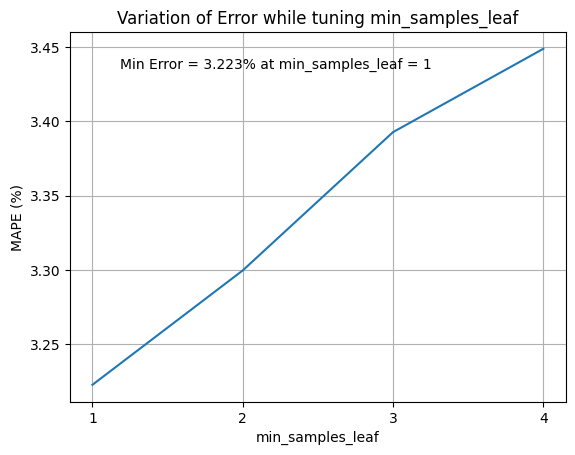


Optimal Feature Set : {'max_features': [2], 'max_samples': [None], 'max_depth': [None], 'min_samples_leaf': [1]}
Best Estimator : RandomForestRegressor(max_features=2, n_estimators=20, n_jobs=-1,
                      random_state=42) 

Tuning Hyperparameter : min_samples_split
Fitting 3 folds for each of 5 candidates, totalling 15 fits


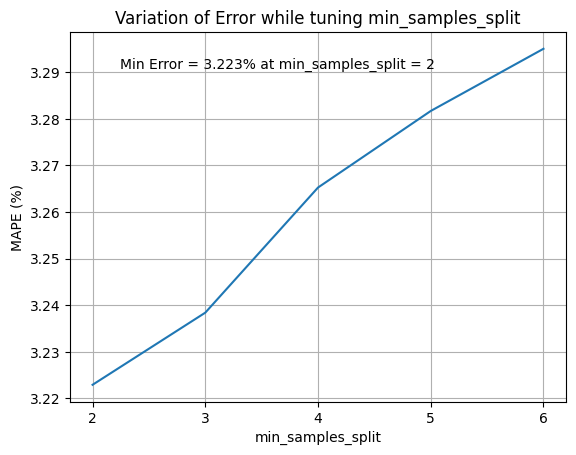


Optimal Feature Set : {'max_features': [2], 'max_samples': [None], 'max_depth': [None], 'min_samples_leaf': [1], 'min_samples_split': [2]}
Best Estimator : RandomForestRegressor(max_features=2, n_estimators=20, n_jobs=-1,
                      random_state=42) 

Tuning Hyperparameter : bootstrap
Fitting 3 folds for each of 2 candidates, totalling 6 fits


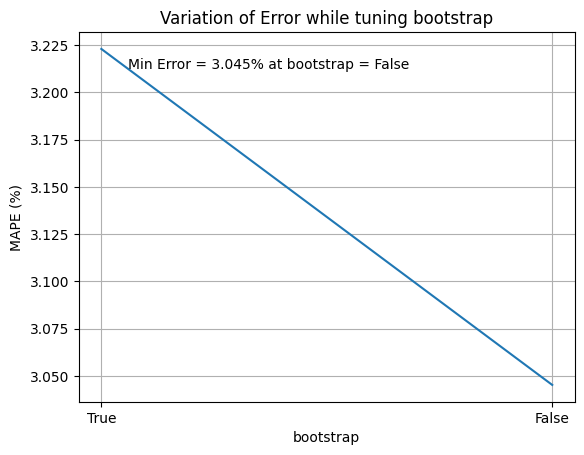


Optimal Feature Set : {'max_features': [2], 'max_samples': [None], 'max_depth': [None], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [False]}
Best Estimator : RandomForestRegressor(bootstrap=False, max_features=2, n_estimators=20,
                      n_jobs=-1, random_state=42) 

Tuning Hyperparameter : n_estimators
Fitting 3 folds for each of 5 candidates, totalling 15 fits


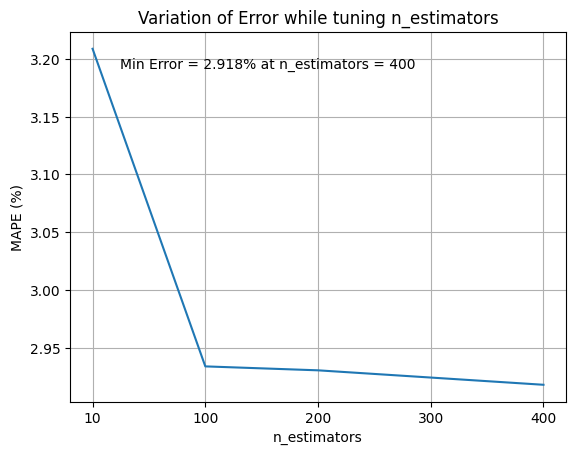


Optimal Feature Set : {'max_features': [2], 'max_samples': [None], 'max_depth': [None], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [False], 'n_estimators': [400]}
Best Estimator : RandomForestRegressor(bootstrap=False, max_features=2, n_estimators=400,
                      n_jobs=-1, random_state=42) 



In [ ]:
rf = RandomForestRegressor(n_estimators=20,random_state=42,n_jobs=-1)
param_grid = {
    'max_features': [1,2,3,4,5,6,7,None],
    'max_samples': [0.6,0.7,0.8,0.9,None],
    'max_depth': [None,10,20,40,60,80,90],
    'min_samples_leaf': [1,2,3,4],
    'min_samples_split' : [2,3,4,5,6],
    'bootstrap' : [True, False],
    'n_estimators': [10,100,200,300,400]
}
pg = {}
for i in range(7):
  k,v = list(param_grid.items())[i]
  pg.update({k:v})
  print("Tuning Hyperparameter :",k)
  pg, gs = hppmtuner(rf,pg,k)
  mts = -gs.cv_results_['mean_test_score']*100
  f, ax = plt.subplots()
  plt.plot(range(len(v)),mts)
  plt.xticks(range(len(v)),[str(i) if i is not None else 'None' for i in v])
  plt.xlabel(k)
  plt.ylabel("MAPE (%)")
  plt.title(f"Variation of Error while tuning {k}")
  er = min(mts)
  mne = f"Min Error = {er:.3f}% at {k} = {v[list(mts).index(er)]}"
  plt.text(0.1,0.9,mne,transform=ax.transAxes)
  plt.grid()
  plt.show()
  print("\nOptimal Feature Set :",pg)
  print("Best Estimator :",gs.best_estimator_,'\n')

In [ ]:
gs.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=2, n_estimators=400,
                      n_jobs=-1, random_state=42)

#### **Final Prediction Model**

In [ ]:
fmodel = RandomForestRegressor(n_estimators=400,max_features=2,bootstrap=False,random_state=42,n_jobs=-1,verbose=1)
fmodel.fit(XTrain,YTrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   38.1s finished


RandomForestRegressor(bootstrap=False, max_features=2, n_estimators=400,
                      n_jobs=-1, random_state=42, verbose=1)

In [ ]:
ypred = fmodel.predict(XTest)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    1.3s finished


In [ ]:
fmape = (abs(YTest-ypred)/YTest * 100).mean()
fmae = abs(YTest-ypred).mean()
print("MAPE =",round(fmape,2),"%")
print("MAE =",round(fmae,2),"MW")

MAPE = 2.69 %
MAE = 87.39 MW


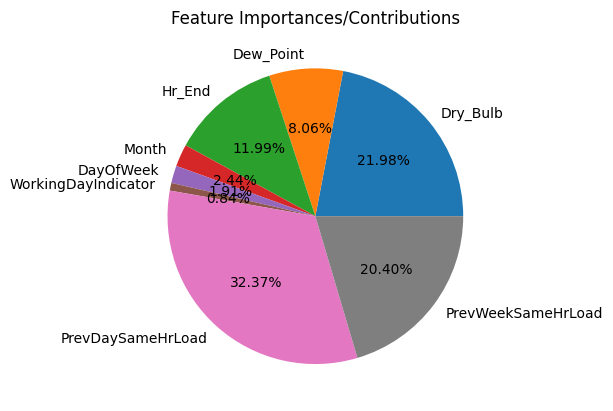

In [ ]:
plt.pie(fmodel.feature_importances_,labels=X.columns,autopct='%.2f%%')
plt.title("Feature Importances/Contributions")
plt.show()

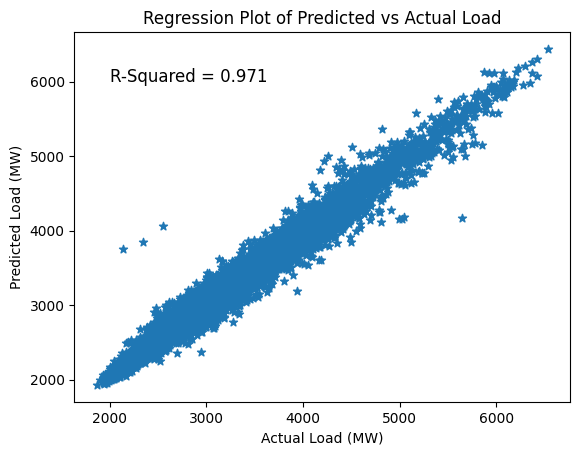

In [ ]:
r2 = r2_score(YTest,ypred)
plt.scatter(YTest,ypred,marker='*')
plt.text(2000, 6000, f'R-Squared = {r2:.3f}', fontsize=12)
plt.title("Regression Plot of Predicted vs Actual Load")
plt.xlabel('Actual Load (MW)')
plt.ylabel('Predicted Load (MW)')
plt.show()

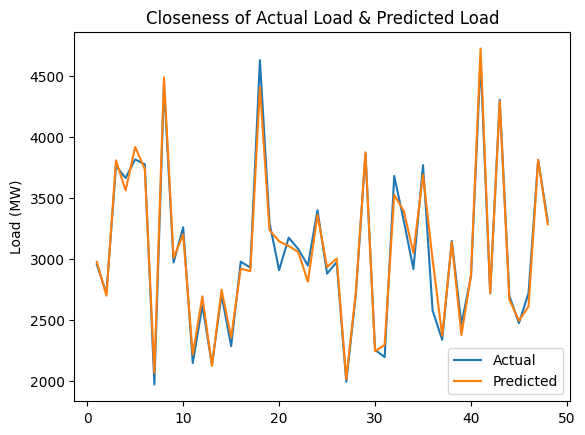

In [ ]:
plt.plot(range(1,len(YTest[2000:2048])+1),YTest[2000:2048],label='Actual')
plt.plot(range(1,len(ypred[2000:2048])+1),ypred[2000:2048],label='Predicted')
plt.title("Closeness of Actual Load & Predicted Load")
plt.ylabel("Load (MW)")
plt.legend()
plt.show()

#### **Day-Ahead Load Forecasting**

In [ ]:
def genPredictors(date,hol=0):
    hrs = 24
    if(pd.to_datetime(date).day_of_week not in [5,6] and hol==0):
        wd = 1
    else:
        wd = 0
    for i in range(len(sep)):
        if sep.iloc[i,0] == pd.to_datetime(date):
            predX = sep.iloc[i:i+hrs]
            prvwk = sep.iloc[i-168:i,4]
            pwdates = np.array(sep.iloc[i-168:i,5])
            break
    dates = np.array(predX['DateTime'])
    predX.loc[:,'Month'] = pd.to_datetime(predX['Date']).dt.month
    predX.loc[:,'DayOfWeek'] = pd.to_datetime(predX['Date']).dt.day_of_week
    predX.loc[:,'WorkingDayIndicator'] = np.array([wd]*hrs)
    predX.loc[:,'PrevDaySameHrLoad'] = np.array(sep.iloc[i-24:i-(24-hrs),4])
    predX.loc[:,'PrevWeekSameHrLoad'] = np.array(sep.iloc[i-168:i-(168-hrs),4])
    yac = np.array(predX['RT_Demand'])
    predX.drop(['Date','RT_Demand','DateTime'],axis=1,inplace=True)
    return predX,yac,prvwk,dates,pwdates

In [ ]:
warnings.filterwarnings("ignore")
fmodel.verbose = 0
sep = pd.read_excel(path.replace("2017_smd_hourly","2023_smd_hourlySept"),sheet_name='CT')
sep = sep[['Date','Dry_Bulb','Dew_Point','Hr_End','RT_Demand']]
sep['DateTime'] = sep['Date'] + pd.to_timedelta(sep['Hr_End'], unit='h')

In [ ]:
dtf = '2023-09-05'
predX, yac, prvwk,dates,pwdates = genPredictors(dtf)
x1 = np.expand_dims(predX,0)
yprd = fmodel.predict(x1[0])
mape2 = (abs(yac - yprd)/yac).mean()*100
mae = abs(yac - yprd).mean()
print(f"MAPE of Day-Ahead Forecast = {mape2:.2f}%")
print(f"MAE of Day-Ahead Forecast = {mae:.2f} MW")

MAPE of Day-Ahead Forecast = 2.00%
MAE of Day-Ahead Forecast = 79.76 MW


In [ ]:
prfudt = np.array(list(pwdates) + [list(dates)[0]])
prfuld = np.array(list(prvwk) + [list(yprd)[0]])

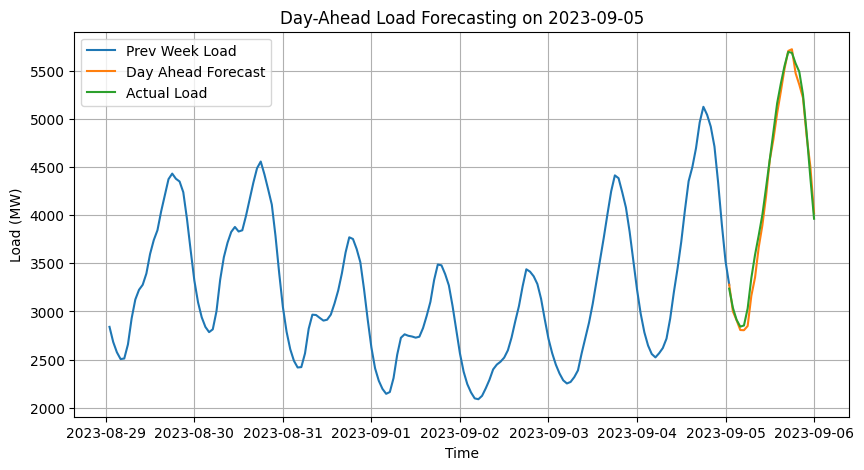

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(prfudt,prfuld,label='Prev Week Load')
plt.plot(dates,yprd,label='Day Ahead Forecast')
plt.plot(dates,yac,label='Actual Load')
plt.title(f"Day-Ahead Load Forecasting on {dtf}")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid()
plt.show()